# T Cells segmentation

To segment the t-cells in the video frames, we will use a combination of information from the different channels available in the dataset. Here's a brief overview of the data:
- Channel 1: NucView BioTracker Caspase 3. This channel primarily features the cancer cells.
- Channel 2: Actin/Tubulin. This channel contains information on both the cancer cells and the t-cells.
- Channel 3: Calcium. This channel captures the calcium signal released by the t-cells, *but is recorded only every 10th frame* (this frequency may vary depending on the video).
- Channel 4: Brightfield Channel. This channel provides outlines of the t-cells and cancer cells.

For segmentation, we will leverage the green channel to train a classifier that can then recognize the t-cells in the red channel. The classifier will be trained using the calcium signal in the green channel as the reference, allowing it to identify the t-cells in the red channel.

An optional post-processing step is applied to refine the t-cell segmentation. Using the mask of the cancer cells (computed from Channel 1), any t-cells overlapping with cancer cells are removed to reduce false positives.

Further refinement of the segmentation mask is carried out in a separate notebook: **`mask_processing`**.

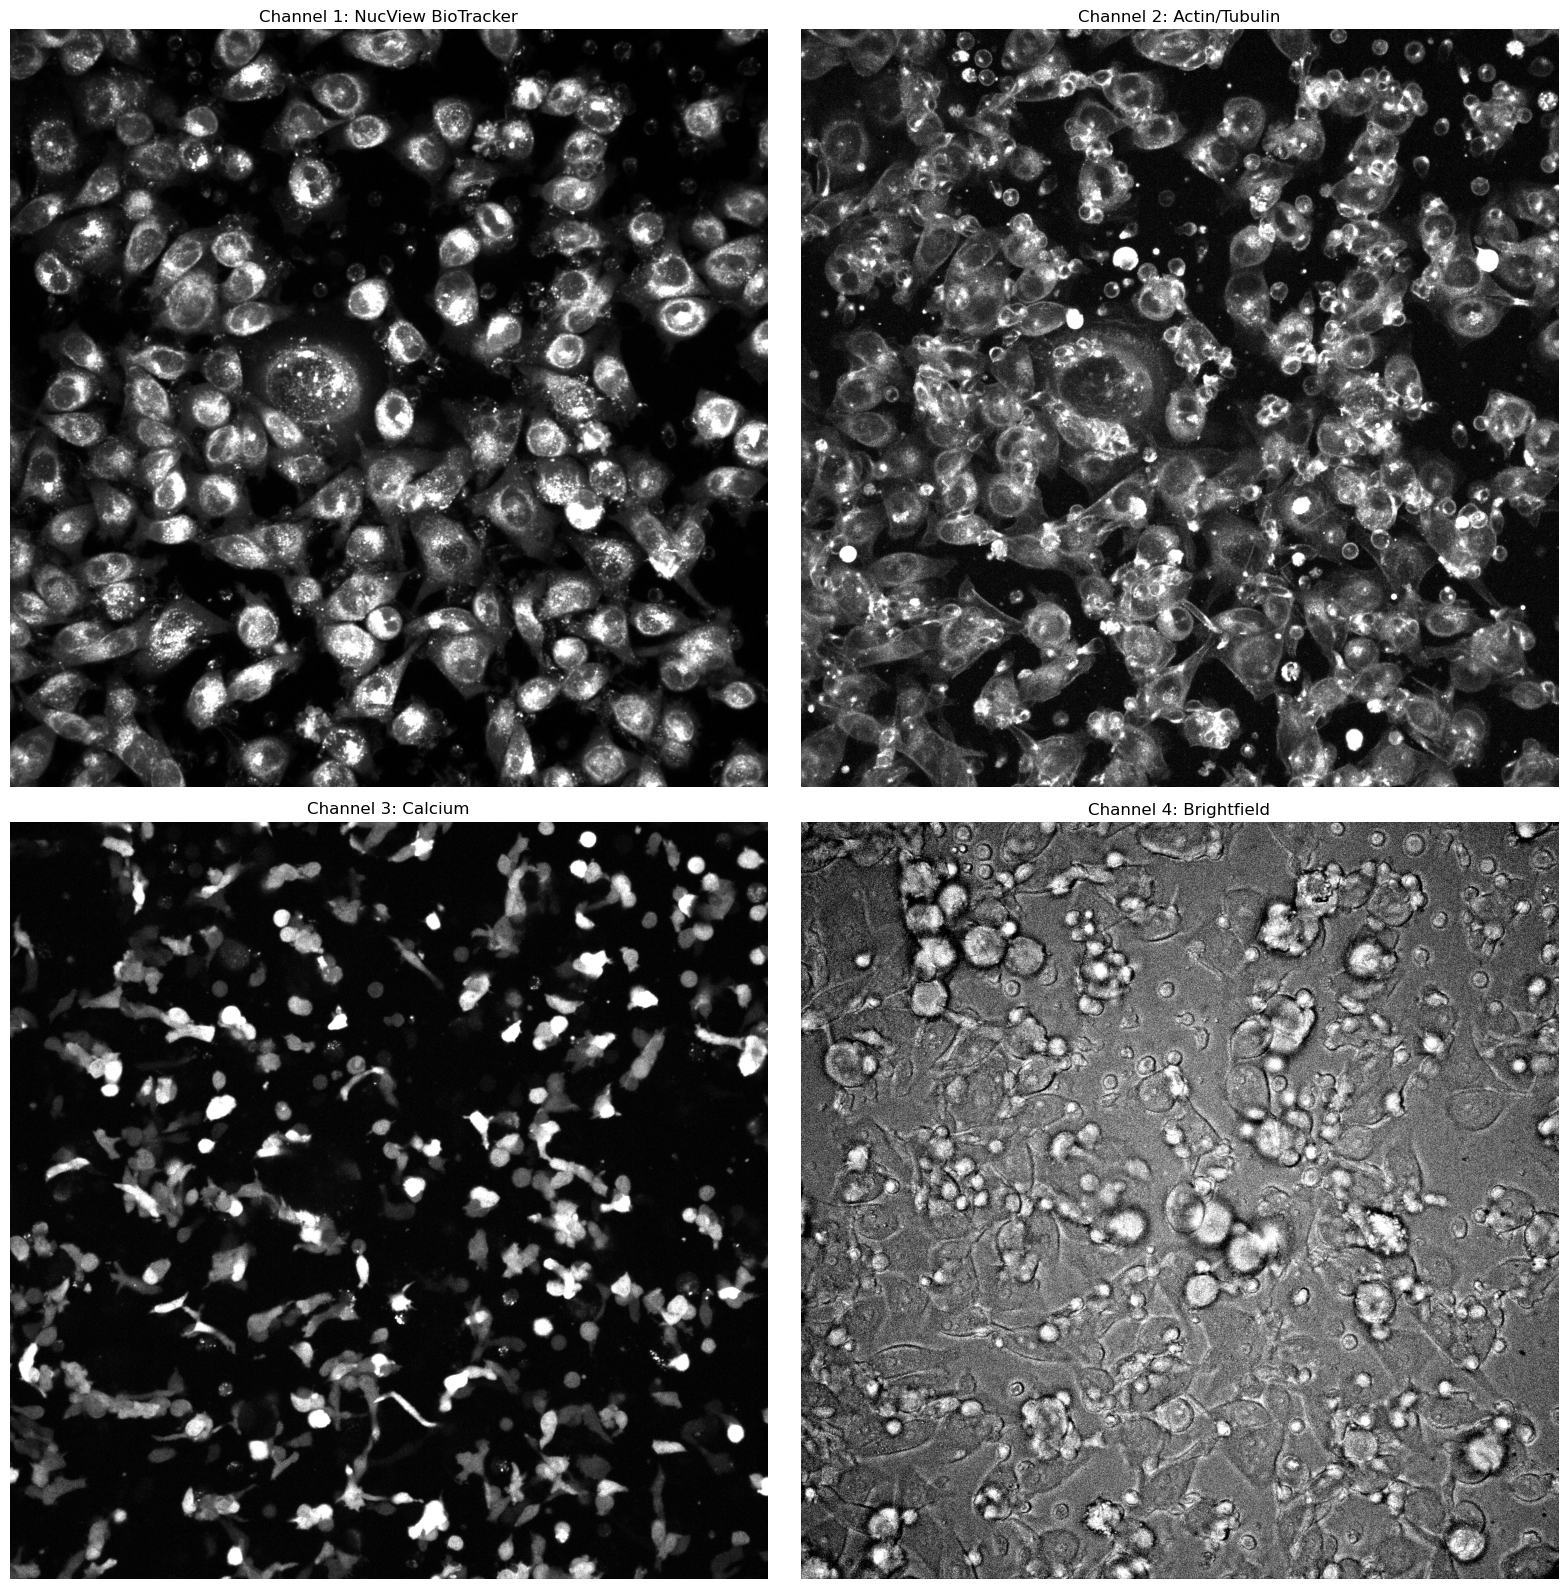

In [76]:
show_images_grid([normalize_grayscale(el) for el in image[0,0:4,:,:]], ["Channel 1: NucView BioTracker", "Channel 2: Actin/Tubulin", "Channel 3: Calcium", "Channel 4: Brightfield"])

## Useful imports and functions

In [45]:
from PIL import Image
import numpy as np
import cv2

from matplotlib import pyplot as plt
import skimage
import imageio.v2 as imageio
from scipy import ndimage

import functools
from sklearn.ensemble import RandomForestClassifier 
import tifffile

from skimage.segmentation import mark_boundaries
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
from tqdm import tqdm

In [73]:
fig_side = 7

def show_image(title, image, cmap='gray'):
    plt.figure(figsize=(fig_side, fig_side))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


def show_images(title1, title2, image1, image2, cmap="gray"):
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(fig_side*2, fig_side))

    # Left: Overlap in grayscale
    axs[0].imshow(image1, cmap='gray')
    axs[0].set_title(title1)
    axs[0].axis('off')

    # Right: Overlay
    axs[1].imshow(image2)
    axs[1].set_title(title2)
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()
    
def show_images_grid(images, titles=None, images_per_row=2, fig_side=8, cmap='gray'):
    num_images = len(images)
    rows = (num_images + images_per_row - 1) // images_per_row

    fig, axs = plt.subplots(rows, images_per_row, figsize=(fig_side * images_per_row, fig_side * rows))

    axs = axs.flatten() if num_images > 1 else [axs]

    for i in range(len(axs)):
        if i < num_images:
            img = images[i]
            title = titles[i] if titles and i < len(titles) else f"Image {i+1}"
            axs[i].imshow(img, cmap=cmap if len(img.shape) == 2 else None)
            axs[i].set_title(title)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()
    

def mask_and(mask1, mask2):
    return np.logical_and(mask1, mask2).astype(np.uint8) * 255


def remove_small_el(mask, area_thr=50, connectivity=8):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=connectivity)

    mask_clean = np.zeros_like(mask)

    for label in range(1, num_labels):  # background label = 0
        area = stats[label, cv2.CC_STAT_AREA]
        if area >= area_thr:
            mask_clean[labels == label] = 1  # Keep the component

    return mask_clean


def overlay_masks(mask1, mask2, alpha=0.3):
    # Ensure masks are binary (0 and 1)
    mask1 = (mask1 > 0).astype(np.uint8)
    mask2 = (mask2 > 0).astype(np.uint8)

    overlap = np.logical_and(mask1, mask2).astype(np.uint8) * 255

    h, w = mask1.shape
    overlay = np.zeros((h, w, 3), dtype=np.float32)

    overlay[..., 0] = mask1 * alpha
    overlay[..., 1] = mask2 * alpha

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(fig_side*2, fig_side))

    # Left: Overlap in grayscale
    axs[0].imshow(overlap, cmap='gray')
    axs[0].set_title("Mask Overlap (White = Intersection)")
    axs[0].axis('off')

    # Right: Overlay
    axs[1].imshow(overlay)
    axs[1].set_title("Overlay: Red = Mask1, Green = Mask2")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

def normalize_grayscale(image, low_perc=2, high_perc=98):
    low = np.percentile(image, low_perc)
    high = np.percentile(image, high_perc)
    clipped = np.clip(image, low, high)
    normalized = (clipped - low) / (high - low)
    return (normalized * 255).astype(np.uint8)

## Upload video file: Change to Desired Video File Name

In [38]:
filename = "./data/series003_cCAR_tumor.tif"
cancer_mask_filename = "./data/series003_cCAR_tumor_mask_cancer_cell.tif"
output_dir = "./output/"

In [40]:
image = imageio.imread(filename)
nb_frames = image.shape[0]

## User inputs
Maunually find the threshold value that best segment the t-cells in the green channel for the specific video, and input it here.

In [ ]:
# User inputs
interval = 10
green_masking_thr = 140

## Training data pre-processing

In [41]:
red_channel = 1
green_channel = 2
smallest_area_th = 150

feature_function = functools.partial(
    skimage.feature.multiscale_basic_features,
    intensity=True,
    edges=True,
    texture=True,
    sigma_min=1,
    sigma_max=6,
)

green_masks = []
green_frames = []
training_red_frames = []

# Storage for all features and labels
X_train = []
y_train = []

i = 0
while i < nb_frames:
    red_frame = image[i, red_channel, :, :]
    green_frame = image[i, green_channel, :, :]  # i-th image, channel, all x, all y 
    
    green_frames.append(green_frame)
    
    normalized_red = normalize_grayscale(red_frame)
    training_red_frames.append(normalized_red)

    green_mask = np.zeros_like(green_frame, dtype=np.uint8)
    green_mask[green_frame > green_masking_thr] = 1
    green_mask = remove_small_el(green_mask, area_thr=smallest_area_th)
    green_mask = (green_mask > 0).astype(np.uint8)
    green_masks.append(green_mask)

    # Extract features from red image
    features = feature_function(normalized_red)

    # Flatten features and labels
    h, w = green_mask.shape
    features_flat = features.reshape(-1, features.shape[-1])
    labels_flat = green_mask.flatten()

    # Use only labeled pixels (label 0 and 1)
    mask = (labels_flat == 0) | (labels_flat == 1)
    X_train.append(features_flat[mask])
    y_train.append(labels_flat[mask])

    i += interval

# Stack all training data
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

## Classifier Model training

The models hyperparameters can be changed.

In [42]:
classifier = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    max_depth=30,
    max_samples=0.5,
    class_weight="balanced",
)
classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30, max_samples=0.5,
                       n_estimators=300, n_jobs=-1)

## Predict and Save

Use the trained model to predict t-cell segmentations on all video frames using the red channel. The resulting segmentations are saved as a multi-frame TIFF file representing the entire video.

In [43]:
# Prediction for all frames of the video.
# Save in one TIFF Image.

preds = []
for i in tqdm(range(nb_frames)):
    red_frame = image[i, red_channel, :, :]    
    test_img = normalize_grayscale(red_frame)
    
    features = feature_function(test_img)
    h, w = test_img.shape
    features_flat = features.reshape(-1, features.shape[-1])
    pred_flat = classifier.predict(features_flat)
    result = pred_flat.reshape(h, w)
    
    result_uint8 = (result * 255).astype(np.uint8)
    preds.append(result_uint8)

tcell_mask_filename = "predictions.tiff"
tifffile.imwrite(output_dir + tcell_mask_filename, np.stack(preds, axis=0))

## Optional Overlay and Save

Overlay the predicted t-cell segmentations onto the corresponding red-channel frames to visually assess segmentation performance. The resulting composite images are saved as a multi-frame TIFF file representing the full video sequence.

In [44]:
# Overlay the Prediction mask of the TCells with the red channel of the video.
# Save in one TIFF Image.

overlays = []
for i in tqdm(range(nb_frames)):
    red_frame = normalize_grayscale(image[i, red_channel, :, :] )
    overlay_rgb = mark_boundaries(img_as_ubyte(red_frame), preds[i], color=(1, 0, 0), mode='thick')
    overlays.append((overlay_rgb * 255).astype(np.uint8))

tifffile.imwrite(output_dir + "overlay_predictions.tiff", np.stack(overlays, axis=0))

## Optional Post-Processing
Remove t-cell segmentation that overlap with the cancer cell segementation.

In [ ]:
cancer_masks = imageio.imread(cancer_mask_filename)
tcell_masks = imageio.imread(tcell_mask_filename)
if (cancer_masks.shape != tcell_masks.shape):
    cancer_masks = skimage.transform.resize(
        cancer_masks,
        tcell_masks.shape,
        order=0,              
        preserve_range=True,   
        anti_aliasing=False
    ).astype(cancer_masks.dtype)

In [ ]:
for i in range(nb_frames):
    cancer_masks[i][cancer_masks[i] != 0] = 1
    tcell_masks[i][tcell_masks[i] != 0] = 1

In [ ]:
final_pred = tcell_masks - cancer_masks
for i in range(nb_frames):
    final_pred[i][final_pred[i] <= 0] = 0

In [ ]:
tifffile.imwrite(output_dir + "masked_predictions.tiff", np.stack(final_pred, axis=0).astype(np.uint8))